In [18]:
from spectacle.core.spectra import Spectrum1D
from spectacle.modeling.models import Absorption1D
from spectacle.core.lines import Line
from spectacle.core.utils import find_bounds

import itertools

import matplotlib.pyplot as plt
# import seaborn as sns
import numpy as np
# , npcorrelate, cross_correlate, autocorrelate, anderson_darling

In [19]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 12]
# plt.rcParams["figure.dpi"] = 80

# Cropping Absorption Features

Line masks are difficult to handle. Ostensibly, we are only interested in the regions that contain absorption, and so we identify absorption regions and crop out the rest of the spectrum. The comparison metric then relies on two sub regions to calculate the correlation value.

However, this raises many issues: what if the size of the absorption regions (and thus the amount of each spectrum included in the calculation) is different? Do we interpolate (non-flux conserving)? Deposit one spectrum on a finer grid such that the number of wavelength bins of the cropped region match, regardless of the resulting bin size? Avoid masking?

Options:

- Logical OR the individual line masks. This provides equal-sized regions, but at the expense of adding unneeded flux values at index-position identified in one spectrum that are not also identified in the other spectrum.
- Resampling for consistent bin count. This method ensures that the regions are equal-sized by resampling the smaller region onto a finer wavelength grid such that the number of bins are the same. This has the consequence of completely losing shape, as a thin absorption region will be made to cover the same index region as wide one.
- Ignore masking. This has the effect of including much of the flux value of at the continuum of a spectrum. Alteratively, using optical depth might be an option.

Below is an analysis on the different ways relevant spectral chunks can be included in the calculations. **Note** that all current correlation metrics use the "Logical OR Masking" method.


In [20]:
# Define the dispersion
disp = np.linspace(1180, 1240, 2000)

def make_cdf(arr, hist=True):
    if hist:
        hist, bin_edges = np.histogram(arr, bins=10000, density=True)
        dx = bin_edges[1] - bin_edges[0]

        return bin_edges[1:], np.cumsum(hist) * dx

    x = np.sort(arr)
    y = np.arange(arr.size)/arr.size
    
    return x, y

# Convenience function to determine shared spectral bounds
def _full_bounds(*args):
    return np.logical_or.reduce([spec.line_mask for spec in args])


line1 = Line(name="HI1216", v_doppler=1e7, column_density=14)
spectrum_model1 = Absorption1D(lines=[line1])
spectrum1 = spectrum_model1(disp)

line2 = Line(name="HI1216", v_doppler=1e7, column_density=14.5, delta_lambda=3)
spectrum_model2 = Absorption1D(lines=[line2])
spectrum2 = spectrum_model2(disp)

## Effect of Logical OR Masking

Logical OR masking is a simple boolean evaluation of the calculated line masks along the length of two spectra. Given two spectra, each with a single absorption feature, the line mask is calculated by a method of determining absorption regions from the continuum and results in a boolean array where true values indicate the location of absorption.

With two boolean flux masks indiciating the regions of the spectra that contain relevant absorption information, the wavelength bin count is guaranteed to be equal.

The caveat to this is that there will be "extra" regions of a spectrum's continuum where the other spectrum's absorption region has been identified.

This, in particular, is not a bad thing -- in fact, it allows the correlations to consider the relative offset between the identified spectral regions in their evaluation.

As a downside, however, the correlation is at the whim of the flux (or optical depth) of the secondary region identified by the second spectrum's mask. This could possible mean that there are unidentified features, or uninstended outliers that get included in the correlation calculation. **This needs to be considered when using real, or synethic data, that contains noise and/or extra absorption features.**

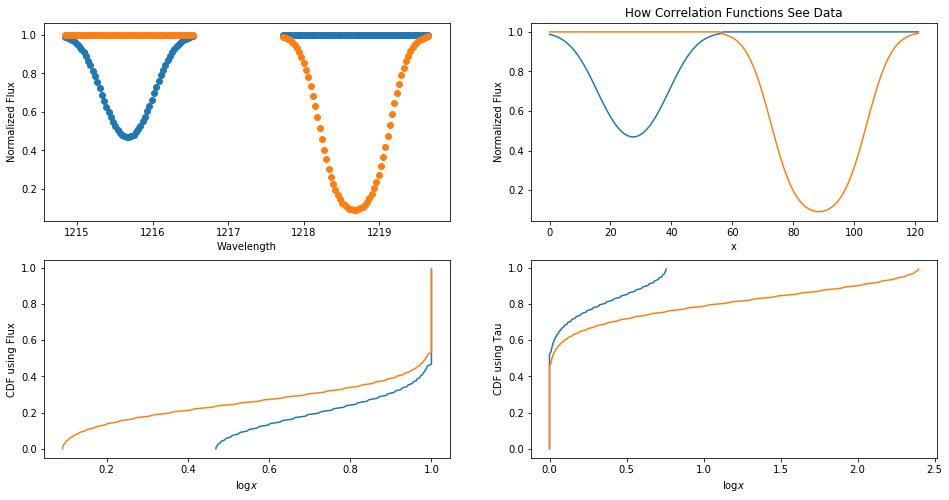

In [21]:
lim_mask = _full_bounds(spectrum1, spectrum2)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
f.set_size_inches(16, 8)
x1, y1 = make_cdf(spectrum1.data[lim_mask], hist=False)
x2, y2 = make_cdf(spectrum2.data[lim_mask], hist=False)
tx1, ty1 = make_cdf(spectrum1.tau[lim_mask], hist=False)
tx2, ty2 = make_cdf(spectrum2.tau[lim_mask], hist=False)

ax1.scatter(spectrum1.dispersion[lim_mask], spectrum1.data[lim_mask])
ax1.scatter(spectrum2.dispersion[lim_mask], spectrum2.data[lim_mask])
ax2.plot(spectrum1.data[lim_mask])
ax2.plot(spectrum2.data[lim_mask])

ax1.set_xlabel("Wavelength")
ax1.set_ylabel("Normalized Flux")

ax2.set_xlabel("x")
ax2.set_ylabel("Normalized Flux")
ax2.set_title("How Correlation Functions See Data")

ax3.plot(x1, y1)
ax3.plot(x2, y2)

ax3.set_xlabel("$\log x$")
ax3.set_ylabel("CDF using Flux")

ax4.plot(tx1, ty1)
ax4.plot(tx2, ty2)

ax4.set_xlabel("$\log x$")
ax4.set_ylabel("CDF using Tau")

## Resampling to Conserve Count

Conserving the bin count by resampling has the uninteded side effect of losing relative positional information, *in addition to* relative shape information.

While the extact flux amount per each feature is thus conserved, it guarantees this by forcing the width of absorption regions to be the same. In so doing, the higher-order information is purposefully removed.

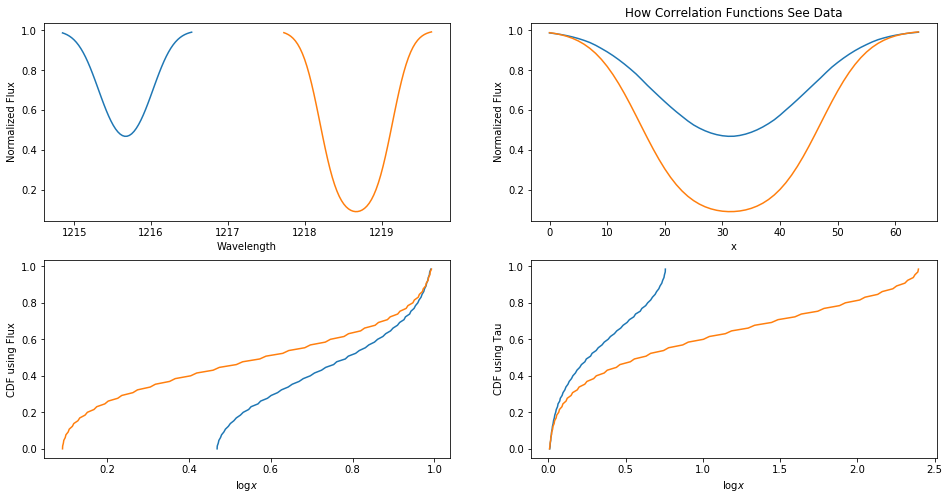

In [22]:
from spectacle.analysis.resample import resample

lim_mask = _full_bounds(spectrum1, spectrum2)

def bin_resamp(a, v, use_tau=False):
    al_disp = a.dispersion[a.line_mask]
    vl_disp = v.dispersion[v.line_mask]
    
    if use_tau:
        al = a.tau[spectrum1.line_mask]
        vl = v.tau[spectrum2.line_mask]
    else:
        al = a.data[spectrum1.line_mask]
        vl = v.data[spectrum2.line_mask]
    
    if al.size > vl.size:
        remat = resample(vl_disp,
                         np.linspace(vl_disp[0], vl_disp[-1], al.size))
        vl = np.dot(remat, vl)
    elif vl.size > al.size:
        remat = resample(al_disp,
                         np.linspace(al_disp[0], al_disp[-1], vl.size))
        al = np.dot(remat, al)
        
    return al, vl

al, vl = bin_resamp(spectrum1, spectrum2)
tal, tvl = bin_resamp(spectrum1, spectrum2, use_tau=True)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
f.set_size_inches(16, 8)
x1, y1 = make_cdf(al, hist=False)
x2, y2 = make_cdf(vl, hist=False)
tx1, ty1 = make_cdf(tal, hist=False)
tx2, ty2 = make_cdf(tvl, hist=False)

ax1.plot(spectrum1.dispersion[spectrum1.line_mask], spectrum1.data[spectrum1.line_mask])
ax1.plot(spectrum2.dispersion[spectrum2.line_mask], spectrum2.data[spectrum2.line_mask])

ax1.set_xlabel("Wavelength")
ax1.set_ylabel("Normalized Flux")

ax2.plot(al)
ax2.plot(vl)

ax2.set_xlabel("x")
ax2.set_ylabel("Normalized Flux")
ax2.set_title("How Correlation Functions See Data")

ax3.plot(x1, y1)
ax3.plot(x2, y2)

ax3.set_xlabel("$\log x$")
ax3.set_ylabel("CDF using Flux")

ax4.plot(tx1, ty1)
ax4.plot(tx2, ty2)

ax4.set_xlabel("$\log x$")
ax4.set_ylabel("CDF using Tau")

## No masking

Below is a comparison of how the correlation functions see the spectral data without masking. In this case, the optical depth actually provides a pretty reasonable CDF.

The downside is that the, in the case of evaluations using flux values, there's much more weight being apportioned to the continuum than to the absorption regions. However, the opposite is true when dealing in optical depth space.

Technical-wise, this is a very expensive approach and requires a long time for correlation evaluations.

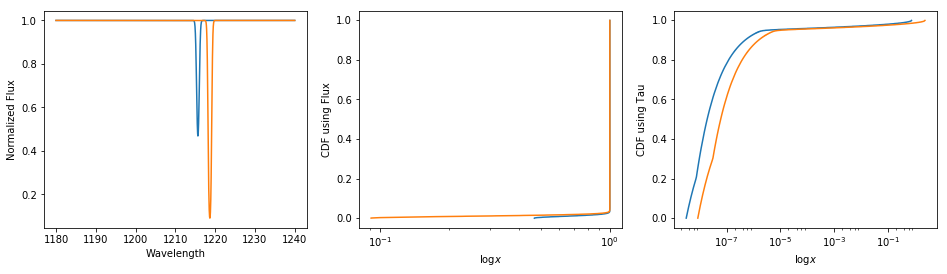

In [23]:
lim_mask = None #_full_bounds(spectrum1, spectrum2)

f, (ax1, ax2, ax3) = plt.subplots(1, 3)
f.set_size_inches(16, 4)
x1, y1 = make_cdf(spectrum1.data, hist=False)
x2, y2 = make_cdf(spectrum2.data, hist=False)
tx1, ty1 = make_cdf(spectrum1.tau, hist=False)
tx2, ty2 = make_cdf(spectrum2.tau, hist=False)

ax1.plot(spectrum1.dispersion, spectrum1.data)
ax1.plot(spectrum2.dispersion, spectrum2.data)

ax1.set_xlabel("Wavelength")
ax1.set_ylabel("Normalized Flux")

ax2.semilogx(x1, y1)
ax2.semilogx(x2, y2)

ax2.set_xlabel("$\log x$")
ax2.set_ylabel("CDF using Flux")

ax3.semilogx(tx1, ty1)
ax3.semilogx(tx2, ty2)

ax3.set_xlabel("$\log x$")
ax3.set_ylabel("CDF using Tau")

# Correlation Metrics

Below is an analysis of correlation metrics. The correlation metrics were calculated using two spectra, each with a single absorption feature ($H\alpha$ to be specific).

The parameter space that explored is composed of three variables: $b$, the Doppler velocity; $N$, the column density; and $\Delta \lambda$, the shift in $\lambda_0$.

The absorption feature in the first spectrum is fixed at $\lambda = 1216 \mathrm{Angstrom}$, $b = 10^6 \mathrm{cm/s}$, $N = 10^{14} \mathrm{cm^{-2}}$. The absorption feature in the second spectrum is allowed to vary.

The plots show the correlation value for a particular combination of $b$ and $N$ between the two spectra (with the first spectrum being fixed as stated above), at a particular wavelength shift $\Delta \lambda$. The first two plots are the correlation using flux and optical depth, respectively. The final plot is of the first, fixed, spectrum (to the left), and the second spectrum at every Doppler and column density combination, but fixed at the greatest wavelength shift.

**Notes**
- Unsure of what's causing the jitter, needs further exploration.

In [24]:
# Define the parameter ranges
v_doppler_range = np.logspace(6, 7, 3)
column_density_range = np.linspace(14, 15, 3)
delta_lambda_range = np.linspace(0, 1, 100)


def generate(corr_func, plot=False):
    f, (ax1, ax2, ax3) = plt.subplots(3, 1)
    
    ax1.set_xlabel("$\Delta \lambda$")
    ax1.set_ylabel("Correlation using Flux")
    
    ax2.set_xlabel("$\Delta \lambda$")
    ax2.set_ylabel("Correlation using Tau")
    
    ax3.set_xlabel("Wavelength [Angstrom]")
    ax3.set_ylabel("Normalized Flux")
    
    def perform_variations(v_dop, col_dens):
        corr, corr_tau = [], []

        line1 = Line(name="HI1216", 
                     v_doppler=v_doppler_range[0], 
                     column_density=column_density_range[0], 
                     delta_lambda=delta_lambda_range[0])

        spectrum_model1 = Absorption1D(lines=[line1])
        spectrum1 = spectrum_model1(disp)

        for dl in delta_lambda_range:
            line2 = Line(name="HI1216", 
                         v_doppler=v_dop, 
                         column_density=col_dens, 
                         delta_lambda=dl)

            spectrum_model2 = Absorption1D(lines=[line2])
            spectrum2 = spectrum_model2(disp)

            res, err, mask = corr_func(spectrum1, spectrum2)
            res_tau, _, _ = corr_func(spectrum1, spectrum2, use_tau=True)
            
            corr.append(res)
            corr_tau.append(res_tau)
        
        ax3.step(spectrum1.velocity(mask=mask), spectrum1.data[mask])
        ax3.step(spectrum2.velocity(mask=mask), spectrum2.data[mask])

        return corr, corr_tau
    
    colors = ['b', 'r', 'g']
    line_styles = ['-', '--', '-.']
    
    for i, v_dop in enumerate(v_doppler_range):
        for j, col_dens in enumerate(column_density_range):
            corr, corr_tau = perform_variations(v_dop, col_dens)
            
            ax1.plot(delta_lambda_range, corr, label="{:g} {:g}".format(v_dop, col_dens), 
                     color=colors[i], linestyle=line_styles[j])
            ax2.plot(delta_lambda_range, corr_tau, label="{:g} {:g}".format(v_dop, col_dens), 
                     color=colors[i], linestyle=line_styles[j])
        
    ax1.legend(loc=0)

## $\xi$ Correlation

A custom correlation function built to provide a normalized value $[0, 1]$ indicating how well two spectra are correlated ($\xi = 1$), or not well correlated ($\xi = 0$). 

\begin{align}
\xi &= \sum_{i=1}^{n} \frac{F_{n}^{a} F_{n}^{v}}{\sqrt{F_{n}^{a}} \sqrt{F_{n}^{v}}}
\end{align}

Considering the behavior in flux-space, the correlation metric seems to be dictated mostly by the $b$-parameter (Doppler value), with smaller Doppler values contributing to an earlier drop in correlation as the two absorption features move farther apart. This could be due to the fact that higher $b$-parameters lead to more physically extended absorption profiles. With longer trailing absorption wings, the correlation metric calculates a smoother falloff.

Likewise, the column density influences the metric much like a scalar; decreasing the correlation as the relative difference between column densities increases. In general, the column density affects the depth of the flux profile, and so contributes to a greater disparity in correlation at specific points along the absorption feature. Since the column density does little to affect the physical spread of the absorption feature, the correlation behavior tends to follow the Doppler value profile as the features move apart.

The behavior in tau-space is much less telling in that variations in column density are completely suppressed. I have yet to come to a conclusion for why this is.

/Users/nmearl/projects/spectacle/spectacle/core/spectra.py:251: RuntimeWarning: divide by zero encountered in log
  self._tau = -np.log(self.data)
/Users/nmearl/projects/spectacle/spectacle/analysis/metrics.py:173: RuntimeWarning: invalid value encountered in true_divide
  unp.sqrt((v ** 2).sum())))
/Users/nmearl/anaconda3/envs/spec_env/lib/python3.6/site-packages/numpy/lib/function_base.py:2652: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


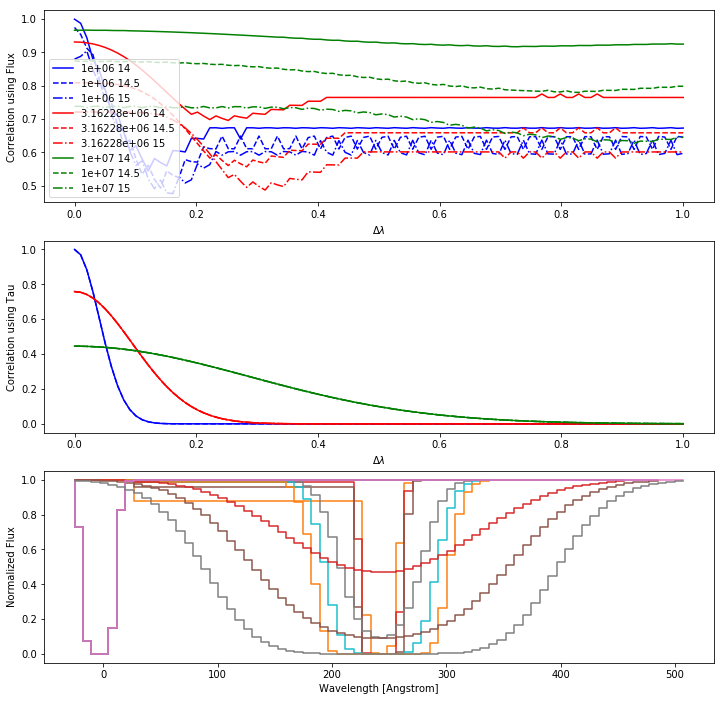

In [25]:
from spectacle.analysis.metrics import correlate

corr_list = generate(correlate)

## NumPy  Statistical Correlation

This method generates a covariance matrix between two vectors, and from the covariance matrix, retrieves the correlation coefficient.

Still exploring the details, but the results are interesting. The correlation value depends most heavily on the Dopper value, which also appears to dictate the behavior of the correlation vs wavelength shift.

/Users/nmearl/projects/spectacle/spectacle/core/spectra.py:251: RuntimeWarning: divide by zero encountered in log
  self._tau = -np.log(self.data)
/Users/nmearl/anaconda3/envs/spec_env/lib/python3.6/site-packages/numpy/lib/function_base.py:2923: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


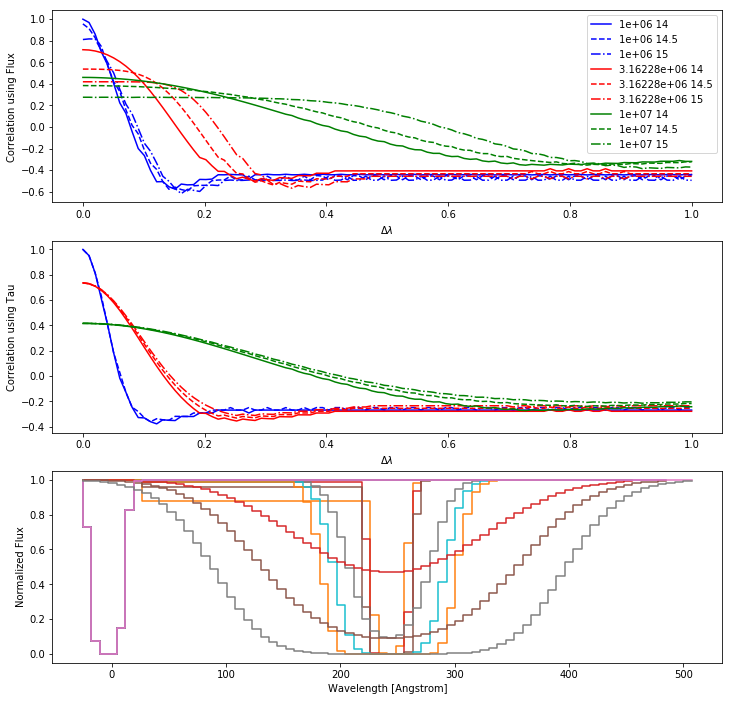

In [26]:
from spectacle.analysis.metrics import cross_correlate, npcorrelate

corr_list = generate(cross_correlate)

# Rank Correlations

When the distribution of variables is not Normal, the degree of relationship between the variables can be determined using Rank correlation. Instead of using the precise values of the variables, the data are ranked in order of size, and calculations are based on the differences between the ranks of corresponding values X and Y.

## Kendall's Tau

Kendall’s $\tau$ is a measure of correlation between two ranked variables. This coefficient depends upon the number of inversions of pairs of objects which would be needed to transform one rank order into the other. The test is non-parametric and does not need to know the nature of the distribution from which the samples were taken.

/Users/nmearl/projects/spectacle/spectacle/core/spectra.py:251: RuntimeWarning: divide by zero encountered in log
  self._tau = -np.log(self.data)


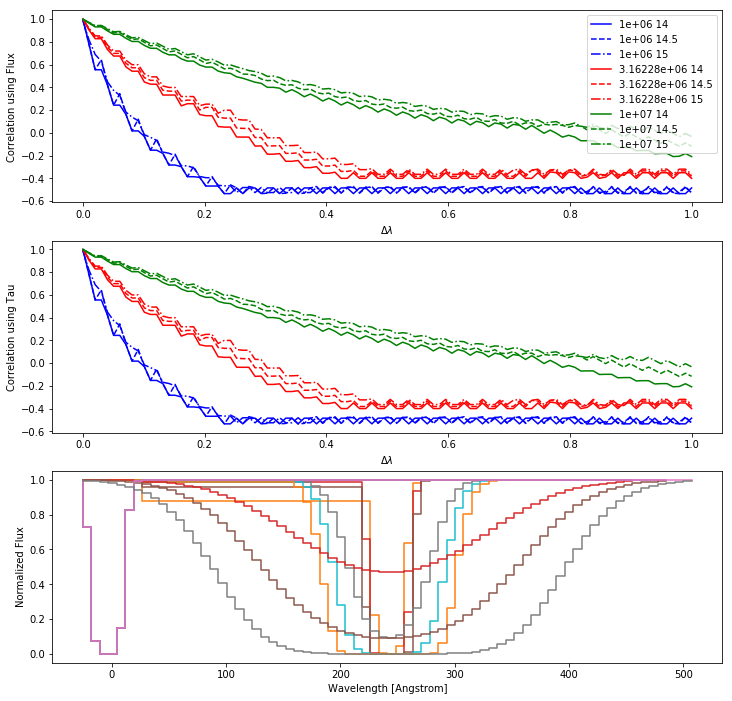

In [27]:
from spectacle.analysis.metrics import kendalls_tau

corr_list = generate(kendalls_tau)

# Goodness of Fit Tests

The goodness of fit (GOF) tests measure the compatibility of a random sample with a theoretical probability distribution function. In other words, these tests show how well the distribution you selected fits to your data.

The general procedure consists of defining a test statistic which is some function of the data measuring the distance between the hypothesis and the data, and then calculating the probability of obtaining data which have a still larger value of this test statistic than the value observed, assuming the hypothesis is true. This probability is called the confidence level.

Small probabilities (say, less than one percent) indicate a poor fit. Especially high probabilities (close to one) correspond to a fit which is too good to happen very often, and may indicate a mistake in the way the test was applied.

## Kolmogorov-Smirnov

The Kolmogorov-Smirnov test (KS-test) tries to determine if two datasets differ significantly. The KS-test has the advantage of making no assumption about the distribution of data. (Technically speaking it is non-parametric and distribution free.) The Kolmogorov-Smirnov test considers the cumulative distribution functions (CDF) instead: construct the empirical CDF of the data points and find its maximum absolute difference K from the theoretical CDF. Due to the limited number of samples, the empirical CDF will be noisy, and K will therefore be a random variable with its own CDF.

In contrast with the simplest tests, this test can detect any deviation in the distributions, but may require a large number of samples to do so, especially in the tails of the distribution.

The Kolmogorov-Smirnov statistic is based on the largest vertical difference between $F_n(x)$ and $F_{n'}(x)$. For two-sample version, it is defined as

\begin{align}
D_{nn'} &= \sqrt{\frac{n n'}{n + n'}} \sup_{x} |F_n(x) - F_{n'}(x)|
\end{align}

The hypothesis regarding the distributional form is rejected at the chosen significance level (alpha) if the test statistic, D, is greater than the critical value obtained from a table (or calculated on-the-fly, as in the case here).

/Users/nmearl/projects/spectacle/spectacle/core/spectra.py:251: RuntimeWarning: divide by zero encountered in log
  self._tau = -np.log(self.data)


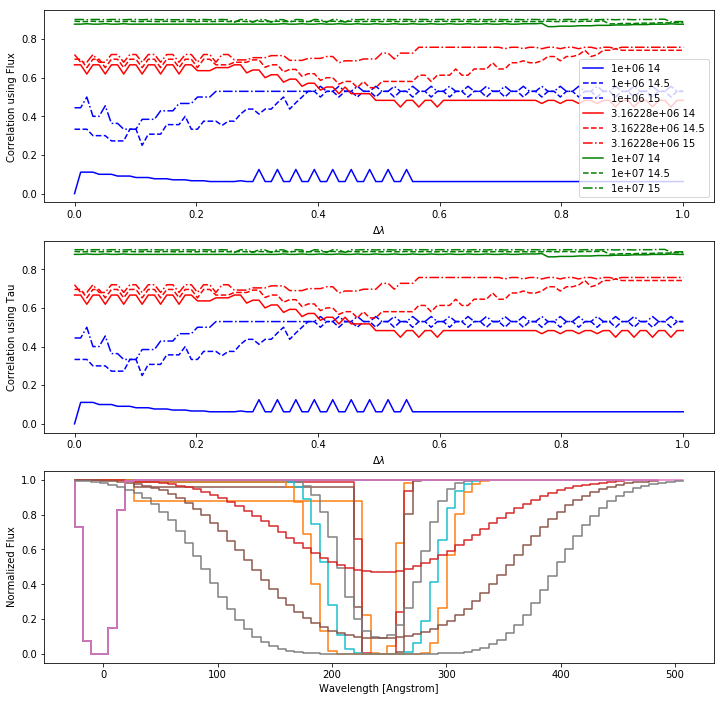

In [28]:
from spectacle.analysis.metrics import kolmogorov_smirnov

corr_list = generate(kolmogorov_smirnov)

## Anderson-Darling 

The AD test has the same advantages mentioned for the KS test in the previous section, namely its sensibility to shape and scale of a distribution and its applicability to small samples (Pettitt, 1976). Specifically, the critical values for the AD test rise asymptotically and converge very quickly towards the asymptote.

In addition, the AD test has two extra advantages over the KS test. First, it is especially sensitive towards differences at the tails of distributions. Second, there is evidence that the AD test is better capable of detecting very small differences, even between large sample sizes.

/Users/nmearl/anaconda3/envs/spec_env/lib/python3.6/site-packages/scipy/stats/morestats.py:1694: UserWarning: approximate p-value will be computed by extrapolation
  warnings.warn("approximate p-value will be computed by extrapolation")
/Users/nmearl/projects/spectacle/spectacle/core/spectra.py:251: RuntimeWarning: divide by zero encountered in log
  self._tau = -np.log(self.data)


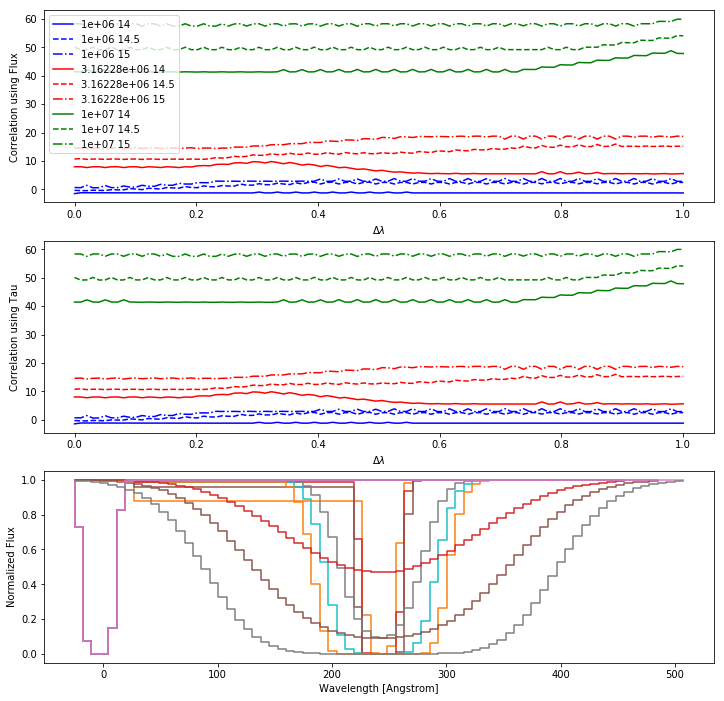

In [29]:
from spectacle.analysis.metrics import anderson_darling

corr_list = generate(anderson_darling)